# General assumptions 

The notebook is built in a way that one can run each question ( 1 and 2) independently. Since there is a code overlap between question 1 and 2 if you want to run question 2 after runing question 1 you can either ignore the cells marked with #* or you can reinitialize runtime and run the notebook from the section "Ερώτημα 2: Convolutional Neural Network" and after.

To load the data fro Exercise 1-3 I have mount my google drive.

To run question 3 you have to run question 2 prior since question 3 is a imporved version of what we did on question 2. Question 3 includes only the needed changes on the code developed on question 2 and of course all the required explanations/comments of the testing proccess.

Also tu run question 4 you have to run question 3 prior in order to save the model. 

In order to keep track of the different changes required in every question I have kept different versions of the network class and training procces (not in all cases) so as one can run seperatly if want to test a specific part of the project. So, the last version in the end of the notebook is the complente network class and the training procces.

#Ερώτημα 1: Feedforward Neural Network

Mount drive to get data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from os import chdir as cd
%cd gdrive/MyDrive
#unzip files
!unzip 'Copy of data.zip'
#move file 
!mv music_genre_data_di ../..
%cd ../..

/content/gdrive/MyDrive
Archive:  Copy of data.zip
   creating: music_genre_data_di/
   creating: music_genre_data_di/test/
   creating: music_genre_data_di/test/melgrams/
  inflating: music_genre_data_di/test/melgrams/X.npy  
  inflating: music_genre_data_di/test/melgrams/labels.npy  
   creating: music_genre_data_di/test/mfccs/
  inflating: music_genre_data_di/test/mfccs/X.npy  
  inflating: music_genre_data_di/test/mfccs/labels.npy  
   creating: music_genre_data_di/train/
   creating: music_genre_data_di/train/melgrams/
  inflating: music_genre_data_di/train/melgrams/X.npy  
  inflating: music_genre_data_di/train/melgrams/labels.npy  
   creating: music_genre_data_di/train/mfccs/
  inflating: music_genre_data_di/train/mfccs/X.npy  
  inflating: music_genre_data_di/train/mfccs/labels.npy  
   creating: music_genre_data_di/val/
   creating: music_genre_data_di/val/melgrams/
  inflating: music_genre_data_di/val/melgrams/X.npy  
  inflating: music_genre_data_di/val/melgrams/labels.npy 

**Βήμα 1: Φόρτωση δεδομένων (mfccs)**

Load data

In [5]:
import pandas as pd
import numpy as np
%cd music_genre_data_di/
#load mfccs
train_X = np.load('train/mfccs/X.npy')
test_X = np.load('test/mfccs/X.npy')
val_X = np.load('val/mfccs/X.npy')
#load labels
train_lbl = np.load('train/mfccs/labels.npy')
test_lbl = np.load('test/mfccs/labels.npy')
val_lbl = np.load('val/mfccs/labels.npy')

/content/music_genre_data_di


In [6]:
train_X.shape


(3200, 26)

Map labels to indexes 

In [7]:
#convert labels to indexes (0-3)
train_lbl_lookup, train_lbl_idx = np.unique(train_lbl, return_inverse=True)
test_lbl_lookup, test_lbl_idx = np.unique(test_lbl, return_inverse=True)
val_lbl_lookup, val_lbl_idx = np.unique(val_lbl, return_inverse=True)

In [8]:
train_lbl_lookup

array(['blues', 'classical', 'hiphop', 'rock_metal_hardrock'],
      dtype='<U19')

Dataloader

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
class Custom_Dataset(Dataset):
  def __init__(self,data,targets, transform= None):
    self.data = data
    # self.targets = torch.LongTensor(targets)
    self.targets = targets
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
      
    if self.transform:
      # x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
      x = self.transform(x)
      y = self.transform(y)      
    return x, y

In [10]:
train_dataset = Custom_Dataset(train_X,train_lbl_idx, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle = True)

validation_dataset = Custom_Dataset(val_X,val_lbl_idx, transform=None)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle = True)

test_dataset = Custom_Dataset(test_X,test_lbl_idx, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle = True)

**Βήμα 2: Ορισμός Νευρωνικού Δικτύου**

Feed Fowrawrd Neural Network

In [11]:
#define netwrok class
class my_Network(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(my_Network, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        return out

Helper functions and imports fror training and validation

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy
import time

#utility function to flaten a list and convert to a numpy array
def convert(array):
  pred_list=[]
  for i in array:
    pred_list.append(i.tolist())
  merged_pred = list(itertools.chain(*pred_list))
  predicted_labels = numpy.array(merged_pred)
  return predicted_labels

**Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης**

In [13]:
def train_(train_dataloader):
  train_batch_losses = []
  pred_arr=[]
  true_arr=[]
  correct = 0

  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch.float())

    #store label baches and their prediction to use for f1 calculation
    _, predicted = torch.max(y_pred, 1) #keep the label with the gratest propability
    true_arr.append(y_batch)
    pred_arr.append(predicted)

    loss = loss_func(y_pred, y_batch)#calculate loss
    train_batch_losses.append(loss.item())

    
    optimizer.zero_grad()#Delete previously stored gradients
    loss.backward()#Perform backpropagation starting from the loss calculated in this epoch
    optimizer.step()#Update model's weights based on the gradients calculated during backprop
  
  #modify baches and prediction shape to calculate f1 score
  train_true = convert(true_arr)
  train_pred = convert(pred_arr)
  return train_true, train_pred, train_batch_losses


**Βήμα 4: Ορισμός διαδικασίας αξιολόγησης**

In [14]:
def validate_(validation_dataloader):
    val_batch_losses = []
    pred_arr=[]
    batch_arr=[]
    correct = 0
    for x_batch, y_batch in validation_dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model(x_batch.float())
      _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability

      #loss calculation per batch
      val_loss = loss_func(y_pred, y_batch)
      val_batch_losses.append(val_loss.item())

      #store baches and their prediction to use for f1 calculation
      batch_arr.append(y_batch)
      pred_arr.append(predicted)

    #modify baches and prediction shape to calculate f1 score
    val_true = convert(batch_arr)
    val_pred = convert(pred_arr)
    return val_true, val_pred, val_batch_losses

**Βήμα 5: Εκπαίδευση δικτύου**

In [15]:
device = torch.device('cpu')
#Define layer sizes
D_in = train_dataset[0][0].shape[0]
H1 = 26
H2 = 128
H3 = 32
D_out = 4 

#Initialize model, loss, optimizer
model = my_Network(D_in, H1, H2, H3, D_out).to(device)

#Define Hyperparameters
learning_rate = 0.002
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Train and validate

Epoch:  1 
 --------------------------
Loss: 
 train:  0.08781271185725928 
 validation:  0.08727064505219459
Accuracy: 
 train:  23.00% 
 validation : 25.00 % 
F1 SCORE: 
 train:  0.20458577360324356  
 validation:  0.1


Epoch:  2 
 --------------------------
Loss: 
 train:  0.08662045311182737 
 validation:  0.08668351620435714
Accuracy: 
 train:  26.00% 
 validation : 25.25 % 
F1 SCORE: 
 train:  0.24505653492602142  
 validation:  0.10538056134330188


Epoch:  3 
 --------------------------
Loss: 
 train:  0.08633407302200795 
 validation:  0.08568364888429642
Accuracy: 
 train:  27.06% 
 validation : 31.50 % 
F1 SCORE: 
 train:  0.25264348607097564  
 validation:  0.21158256171738643


Epoch:  4 
 --------------------------
Loss: 
 train:  0.08574308898299933 
 validation:  0.0854034562408924
Accuracy: 
 train:  30.44% 
 validation : 34.12 % 
F1 SCORE: 
 train:  0.3027390469987543  
 validation:  0.2387609649122807


Epoch:  5 
 --------------------------
Loss: 
 train:  0.085307

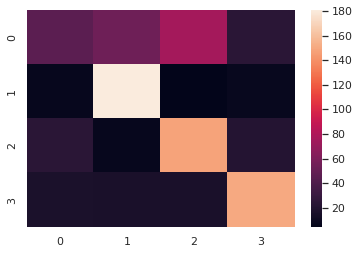

In [17]:
start = time.time()

train_loss_history = []
val_loss_history = []
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(30):
  train_batch_losses = []
  val_batch_losses = []
  
  #train
  model.train()
  train_true, train_pred, train_batch_losses = train_(train_dataloader)

  #validate
  with torch.no_grad():  
    val_true, val_pred, val_batch_losses = validate_(validation_dataloader)
    
  #calculate f1_score
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')

  #calculate accuracy
  train_acc = accuracy_score(train_true, train_pred, )
  val_acc = accuracy_score(val_true, val_pred, )

  #calculate loss
  train_loss = sum(train_batch_losses)/len(train_dataloader.dataset)
  val_loss = sum(val_batch_losses)/len(validation_dataloader.dataset)

  print("Epoch: " , epoch+1 , "\n --------------------------")
  print("Loss: \n train: ", train_loss, "\n validation: ", val_loss)
  # print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print(f"Accuracy: \n train:  {100*train_acc:.2f}% \n validation : {100*val_acc:.2f} % "  )
  print("F1 SCORE: \n train: ", f1_train ," \n validation: ", f1_val)

  print("\n")

  #calclulate confusion matrix
  if epoch == 29:
    print("Confusion Matrix")
    results = confusion_matrix(val_true, val_pred)
    ax = sns.heatmap(results)

  #store loss or each epoch
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader.dataset))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader.dataset))

#calculate time
stop = time.time()
print(f"Training time: {stop - start}s")

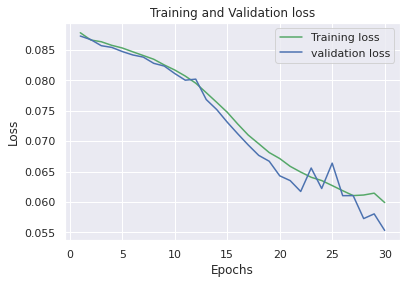

In [18]:
import matplotlib.pyplot as plt
epochs = range(1,31)
# loss in train_loss_history
plt.plot(epochs, train_loss_history, 'g', label='Training loss')
plt.plot(epochs, val_loss_history, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Βήμα 6: Εκπαίδευση δικτύου με GPU**

Using CPU training time equals to 15.065938711166382 sec \\
Using GPU training time equals to 5.245940446853638 sec \\
The gap in this case is not so big since we do not use a large amount of data but using GPU is clearly faster. (The printed results above are from the last run using GPU)

**Βήμα 7: Επιλογή μοντέλου**

Lets train and validate again the model. This time some new lines of code are added in order to save the version of the model which reach the best accuracy.

This method of training/validation procces will be used in the other exercises too.

Epoch:  1 
 --------------------------
Loss: 
 train:  0.05967942243441939 
 validation:  0.056573930010199544
Accuracy: 
 train:  59.72% 
 validation : 64.38 % 
F1 SCORE: 
 train:  0.5743366649054255  
 validation:  0.6415695515117754


Epoch:  2 
 --------------------------
Loss: 
 train:  0.05942501483485103 
 validation:  0.06179957650601864
Accuracy: 
 train:  58.97% 
 validation : 55.25 % 
F1 SCORE: 
 train:  0.574095762941633  
 validation:  0.5373690705792467


Epoch:  3 
 --------------------------
Loss: 
 train:  0.060086280535906554 
 validation:  0.05478656090795994
Accuracy: 
 train:  59.16% 
 validation : 64.50 % 
F1 SCORE: 
 train:  0.5752910296027628  
 validation:  0.6352767796782802


Epoch:  4 
 --------------------------
Loss: 
 train:  0.05916217666119337 
 validation:  0.055951225608587264
Accuracy: 
 train:  60.97% 
 validation : 62.75 % 
F1 SCORE: 
 train:  0.5943170463246633  
 validation:  0.610932171663354


Epoch:  5 
 --------------------------
Loss: 
 trai

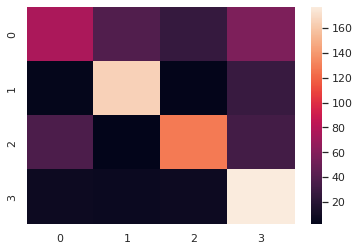

In [19]:
train_loss_history = []
val_loss_history = []
start = time.time()

prev_loss = 100

for epoch in range(30):
  train_batch_losses = []
  val_batch_losses = []
  
  #train
  model.train()
  train_true, train_pred, train_batch_losses = train_(train_dataloader)

  #validate
  with torch.no_grad():  
    val_true, val_pred, val_batch_losses = validate_(validation_dataloader)
    
  #calculate f1_score
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')

  #calculate accuracy
  train_acc = accuracy_score(train_true, train_pred, )
  val_acc = accuracy_score(val_true, val_pred, )

  #calculate loss
  train_loss = sum(train_batch_losses)/len(train_dataloader.dataset)
  val_loss = sum(val_batch_losses)/len(validation_dataloader.dataset)

  if val_loss < prev_loss:
    torch.save(model, "model_path.pth")#save model
    prev_loss = val_loss#save loss

  print("Epoch: " , epoch+1 , "\n --------------------------")
  print("Loss: \n train: ", train_loss, "\n validation: ", val_loss)
  # print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print(f"Accuracy: \n train:  {100*train_acc:.2f}% \n validation : {100*val_acc:.2f} % "  )
  print("F1 SCORE: \n train: ", f1_train ," \n validation: ", f1_val)

  print("\n")

  #calclulate confusion matrix
  if epoch == 29:
    results = confusion_matrix(val_true, val_pred)
    print("Confusion Matrix after 30 epochs:")
    ax = sns.heatmap(results)

  #store loss or each epoch
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader.dataset))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader.dataset))

#calculate time
stop = time.time()
print(f"Training time: {stop - start}s")

Validate mode using test set

In [20]:
#test
model = torch.load("model_path.pth").to(device)

with torch.no_grad():  
  test_true, test_pred, test_batch_losses = validate_(test_dataloader)
  
#calculate f1_score
f1_test = f1_score(test_true, test_pred, average='weighted')

#calculate accuracy
test_acc = accuracy_score(test_true, test_pred, )

#calculate loss
test_loss = sum(test_batch_losses)/len(test_dataloader.dataset)

print("Loss: \n test: ", test_loss)
# print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
print(f"Accuracy: \ntest : {100*test_acc:.2f} % "  )
print("F1 SCORE: \n  test: ", f1_test)

Loss: 
 test:  0.05751518996129202
Accuracy: 
test : 63.81 % 
F1 SCORE: 
  test:  0.6214513064849154


#Ερώτημα 2: Convolutional Neural Network

**Βήμα 1: Φόρτωση δεδομένων**

In [1]:
#*
from google.colab import drive
drive.mount('/content/gdrive')

from os import chdir as cd
%cd gdrive/MyDrive
#unzip files
!unzip 'Copy of data.zip'
#move file 
!mv music_genre_data_di ../..
%cd ../..

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive
Archive:  Copy of data.zip
replace music_genre_data_di/test/melgrams/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/test/melgrams/labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/test/mfccs/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/test/mfccs/labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/train/melgrams/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/train/melgrams/labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/train/mfccs/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/train/mfccs/labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace music_genre_data_di/val/melgrams/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replac

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

In [3]:
%cd music_genre_data_di/
#load melgrams
train_X = np.load('train/melgrams/X.npy')
test_X = np.load('test/melgrams/X.npy')
val_X = np.load('val/melgrams/X.npy')
#load labels
train_lbl = np.load('train/melgrams/labels.npy')
test_lbl = np.load('test/melgrams/labels.npy')
val_lbl = np.load('val/melgrams/labels.npy')

/content/music_genre_data_di


Map labels to indicies

In [4]:
#convert labels to indexes (0-3)
train_lbl_lookup, train_lbl_idx = np.unique(train_lbl, return_inverse=True)
test_lbl_lookup, test_lbl_idx = np.unique(test_lbl, return_inverse=True)
val_lbl_lookup, val_lbl_idx = np.unique(val_lbl, return_inverse=True)

Visualization

In [5]:
blues = np.where(train_lbl == 'blues')
blues = blues[0][10]
classical =np.where(train_lbl == 'classical')
classical = classical[0][0]
hiphop = np.where(train_lbl == 'hiphop')
hiphop = hiphop[0][50]
rock = np.where(train_lbl == 'rock_metal_hardrock')
rock = rock[0][7]

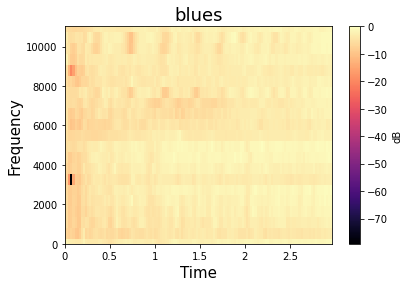

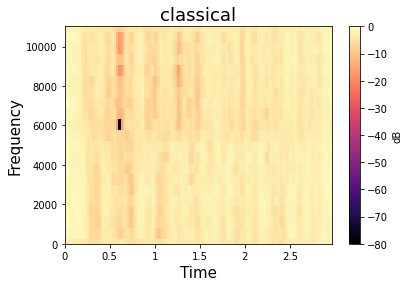

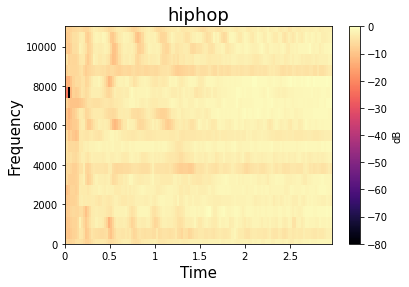

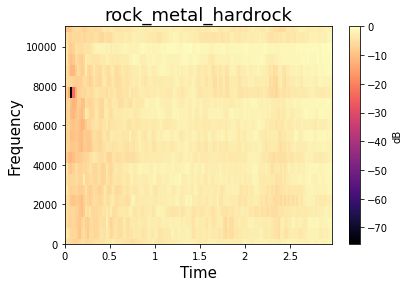

In [6]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torchaudio

array = [blues, classical, hiphop, rock]
names = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
for i in range(4):
  spectrogram = np.abs(train_X[array[i]])
  power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
  # plt.figure(figsize=(8, 7))
  # librosa.display.specshow(power_to_db, sr=22050, x_axis='time', y_axis='mel', cmap='magma', hop_length=hop_length)
  img = librosa.display.specshow(power_to_db, x_axis='time', y_axis='linear')
  plt.colorbar(label='dB')
  plt.title(names[i], fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Frequency', fontdict=dict(size=15))
  plt.show()

Data loaders

In [7]:
#*
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
class Custom_Dataset(Dataset):
  def __init__(self,data,targets, transform= None):
    self.data = data
    self.targets = targets
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
      
    if self.transform:
      x = self.transform(x)
      y = self.transform(y)      
    return x, y

**Βήμα 2:Δημιουργία του Δικτύου και Βήμα 4: Pooling and padding**

In [8]:
class convNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5, padding = 2)
    self.conv3 = nn.Conv2d(32, 64, 5, padding = 2)
    self.conv4 = nn.Conv2d(64, 128, 5, padding = 2)

    self.max_pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.2)
    
    self.linear1 = nn.Linear(1024, 1024)
    self.linear2 = nn.Linear(1024, 256)
    self.linear3 = nn.Linear(256, 32)
    self.linear4 = nn.Linear(32, 4)
    # self.linear5 = nn.Linear(4, 4)
    

  def forward(self, x):
      x = self.max_pool(self.conv1(x))
      x = self.max_pool(self.conv2(x))
      x = self.max_pool(self.conv3(x))
      x = self.max_pool(self.conv4(x))
      x = x.view(x.size(0), -1)
     
      out = self.linear1(x)
      out = self.linear2(out)
      out = self.linear3(out)
      out = self.linear4(out)
      return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = convNet().to(device)

Train and validation loop definition

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy

#utility function to flaten a list and convert to a numpy array
def convert(array):
  pred_list=[]
  for i in array:
    pred_list.append(i.tolist())
  merged_pred = list(itertools.chain(*pred_list))
  predicted_labels = numpy.array(merged_pred)
  return predicted_labels

In [10]:
def train_(train_dataloader):
  train_batch_losses = []
  pred_arr=[]
  true_arr=[]
  correct = 0

  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    x_batch = torch.unsqueeze(x_batch,1)
    y_pred = model(x_batch.float())

    #store label baches and their prediction to use for f1 calculation
    _, predicted = torch.max(y_pred, 1) #keep the label with the gratest propability
    true_arr.append(y_batch)
    pred_arr.append(predicted)

    loss = loss_func(y_pred, y_batch)#calculate loss
    train_batch_losses.append(loss.item())

    
    optimizer.zero_grad()#Delete previously stored gradients
    loss.backward()#Perform backpropagation starting from the loss calculated in this epoch
    optimizer.step()#Update model's weights based on the gradients calculated during backprop
  
  #modify baches and prediction shape to calculate f1 score
  train_true = convert(true_arr)
  train_pred = convert(pred_arr)
  return train_true, train_pred, train_batch_losses


def validate_(validation_dataloader):
    val_batch_losses = []
    pred_arr=[]
    batch_arr=[]
    correct = 0
    for x_batch, y_batch in validation_dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      x_batch = torch.unsqueeze(x_batch,1)
      y_pred = model(x_batch.float())
      _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability

      #loss calculation per batch
      val_loss = loss_func(y_pred, y_batch)
      val_batch_losses.append(val_loss.item())

      #store baches and their prediction to use for f1 calculation
      batch_arr.append(y_batch)
      pred_arr.append(predicted)

  
    #modify baches and prediction shape to calculate f1 score
    val_true = convert(batch_arr)
    val_pred = convert(pred_arr)
    return val_true, val_pred, val_batch_losses

**Βήμα 3: Εκπαίδευση δικτύου**

Train procces

Epoch:  1 
 --------------------------
Loss: 
 train:  0.08379860490560531 
 validation:  0.07840479716658592
Accuracy: 
 train:  33.19% 
 validation : 42.50 % 
F1 SCORE: 
 train:  0.30350946286208935  
 validation:  0.3677378187658237


Epoch:  2 
 --------------------------
Loss: 
 train:  0.07486870048567652 
 validation:  0.06941369265317916
Accuracy: 
 train:  42.34% 
 validation : 48.12 % 
F1 SCORE: 
 train:  0.40417707025007  
 validation:  0.4298073097694616


Epoch:  3 
 --------------------------
Loss: 
 train:  0.06677978456020356 
 validation:  0.06413722954690457
Accuracy: 
 train:  51.16% 
 validation : 49.25 % 
F1 SCORE: 
 train:  0.4966376305727866  
 validation:  0.4224021241399621


Epoch:  4 
 --------------------------
Loss: 
 train:  0.062276796456426385 
 validation:  0.06369049370288848
Accuracy: 
 train:  54.53% 
 validation : 53.87 % 
F1 SCORE: 
 train:  0.5343246781273043  
 validation:  0.5350180802381432


Epoch:  5 
 --------------------------
Loss: 
 train

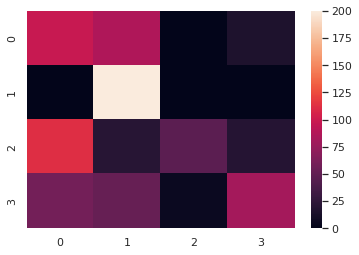

In [11]:
# define the corresponding loss function and the optimizer
loss_func = nn.CrossEntropyLoss()
lr_ = 0.002
epochs = 30
# 1e-3
# optimizer = optim.Adam(model.parameters(), lr = lr_)
# optimizer = optim.AdamW(model.parameters(), lr = lr_)
# optimizer = optim.SparseAdam(model.parameters(), lr = lr_)
# optimizer = optim.Adamax(model.parameters(), lr = lr_)
# optimizer = optim.Adadelta(model.parameters(), lr = lr_)
# optimizer = optim.Adagrad(model.parameters(), lr = lr_)
# optimizer = optim.ASGD(model.parameters(), lr = lr_)
# optimizer = optim.LBFGS(model.parameters(), lr = lr_)
# optimizer = optim.NAdam(model.parameters(), lr = lr_)
# optimizer = optim.RAdam(model.parameters(), lr = lr_)
# optimizer = optim.RMSprop(model.parameters(), lr = lr_)
# optimizer = optim.Rprop(model.parameters(), lr = lr_)
optimizer = optim.SGD(model.parameters(), lr = lr_)

b_sz = 16
train_dataset = Custom_Dataset(train_X,train_lbl_idx, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=b_sz, shuffle = True)

validation_dataset = Custom_Dataset(val_X,val_lbl_idx, transform=None)
validation_dataloader = DataLoader(validation_dataset, batch_size=b_sz, shuffle = True)


train_loss_history = []
val_loss_history = []
prev_loss = 1000

for epoch in range(epochs):
  train_batch_losses = []
  val_batch_losses = []
  
  #train
  model.train()
  train_true, train_pred, train_batch_losses = train_(train_dataloader)

  #validate
  with torch.no_grad():  
    val_true, val_pred, val_batch_losses = validate_(validation_dataloader)
    
  #calculate f1_score
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')

  #calculate accuracy
  train_acc = accuracy_score(train_true, train_pred, )
  val_acc = accuracy_score(val_true, val_pred, )

  #calculate loss
  train_loss = sum(train_batch_losses)/len(train_dataloader.dataset)
  val_loss = sum(val_batch_losses)/len(validation_dataloader.dataset)

  if val_loss < prev_loss:
    torch.save(model, "model_path.pth")#save model
    prev_loss = val_loss#save loss

  print("Epoch: " , epoch+1 , "\n --------------------------")
  print("Loss: \n train: ", train_loss, "\n validation: ", val_loss)
  # print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print(f"Accuracy: \n train:  {100*train_acc:.2f}% \n validation : {100*val_acc:.2f} % "  )
  print("F1 SCORE: \n train: ", f1_train ," \n validation: ", f1_val)

  print("\n")

  #calclulate confusion matrix
  if epoch == 29:
    print('confusion matrix')
    results = confusion_matrix(val_true, val_pred)
    ax = sns.heatmap(results)

  #store loss or each epoch
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader.dataset))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader.dataset))

EVALUATION (test set)

Loss: 
 test:  0.04615830865060521
Accuracy: 
test : 72.38 % 
F1 SCORE: 
  test:  0.7231476953248166

 confusion matrix


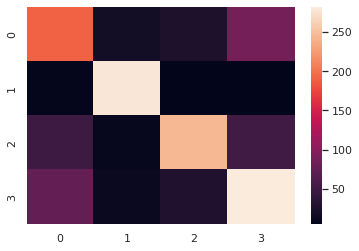

In [12]:
test_dataset = Custom_Dataset(test_X,test_lbl_idx, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=b_sz, shuffle = True)
model = torch.load("model_path.pth").to(device)

with torch.no_grad():  
  test_true, test_pred, test_batch_losses = validate_(test_dataloader)
    
  #calculate f1_score
  f1_test = f1_score(test_true, test_pred, average='weighted')

  #calculate accuracy
  test_acc = accuracy_score(test_true, test_pred, )

  #calculate loss
  test_loss = sum(test_batch_losses)/len(test_dataloader.dataset)

  print("Loss: \n test: ", test_loss)
  print(f"Accuracy: \ntest : {100*test_acc:.2f} % "  )
  print("F1 SCORE: \n  test: ", f1_test)
  print('\n confusion matrix')
  results = confusion_matrix(test_true, test_pred)
  ax = sns.heatmap(results)

**Βήμα 5: Αλγόριθμοι βελτιστοποίησης**

Using learning rate = 0.002 and 30 epochs with batch size 16 we get the following results for different optimizers.
Below is shown tha Accuracy and F1 score for the test set.

I have not perform any seed operation until now on the code so if we run again the code trying to reproduce the results shown below the values of the table may differ.

\begin{array}{ccccccccc}
\text{metric}&\text{Adam}&\text{AdamW}&\text{NAdam}&\text{RAdam}&\text{Adagrad}&\text{RMSprop}&\text{Rprop}&\text{ASGD}&\text{SGD}\\
F1\_score & 60.54\% & 56.98\% & 71.37\% & 50.36\% & 66.06\% & 49.93\% &  64.10\% & 69.40\% & 71.73\% \\
Accuracy & 61\% & 55\% & 70\% & 51\% & 64\% &49\% & 64\% & 68\% & 71\% 
\end{array}


#Ερώτημα 3: Improving Performance

To run this question ine has first run question 2. Here, i have included only the cells that need changes and rerun question two.

Βήμα 1: Reproducibility

Rruning the code below we are able to seed our parameters

In [13]:
import random, os
import time
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
torch_seed(100)

**Βήμα 2: Activation functions**

Redefining the network defined previously on question two. 

In [14]:
class convNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    #convolutional layers
    self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)  # in channels, out_channels, kernel_size
    self.conv2 = nn.Conv2d(16, 32, 5, padding = 2)
    self.conv3 = nn.Conv2d(32, 64, 5, padding = 2)
    self.conv4 = nn.Conv2d(64, 128, 5, padding = 2)

    #max pool and non linear layer
    self.max_pool = nn.MaxPool2d(2,2)
    self.non_linear = nn.SELU()

    #batch normalization layers
    self.batch_norm1 = nn.BatchNorm2d(16)
    self.batch_norm2 = nn.BatchNorm2d(32)
    self.batch_norm3 = nn.BatchNorm2d(64)
    self.batch_norm4 = nn.BatchNorm2d(128)
    
    #linear layers
    self.linear1 = nn.Linear(1024, 1024)
    self.linear2 = nn.Linear(1024, 256)
    self.linear3 = nn.Linear(256, 32)
    self.linear4 = nn.Linear(32, 4)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
      # x = self.max_pool(self.non_linear(self.conv1(x)))
      # x = self.max_pool(self.non_linear(self.conv2(x)))
      # x = self.max_pool(self.non_linear(self.conv3(x)))
      # x = self.max_pool(self.non_linear(self.conv4(x)))
      x = self.max_pool(self.batch_norm1(self.non_linear(self.conv1(x))))
      x = self.max_pool(self.batch_norm2(self.non_linear(self.conv2(x))))
      x = self.max_pool(self.batch_norm3(self.non_linear(self.conv3(x))))
      x = self.max_pool(self.batch_norm4(self.non_linear(self.conv4(x))))

      x = x.view(x.size(0), -1)
  
      # x = self.dropout(x)
      out = self.linear1(x)
      out = self.linear2(out)
      out = self.linear3(out)
      out = self.linear4(out)
      return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = convNet().to(device)

In [15]:
def train_(train_dataloader):
  train_batch_losses = []
  pred_arr=[]
  true_arr=[]
  correct = 0

  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    x_batch = torch.unsqueeze(x_batch,1)
    y_pred = model(x_batch.float())

    #store label baches and their prediction to use for f1 calculation
    _, predicted = torch.max(y_pred, 1) #keep the label with the gratest propability
    true_arr.append(y_batch)
    pred_arr.append(predicted)

    loss = loss_func(y_pred, y_batch)#calculate loss
    train_batch_losses.append(loss.item())

    
    optimizer.zero_grad()#Delete previously stored gradients
    loss.backward()#Perform backpropagation starting from the loss calculated in this epoch
    optimizer.step()#Update model's weights based on the gradients calculated during backprop
  scheduler1.step()

  #modify baches and prediction shape to calculate f1 score
  train_true = convert(true_arr)
  train_pred = convert(pred_arr)
  return train_true, train_pred, train_batch_losses


def validate_(validation_dataloader):
    val_batch_losses = []
    pred_arr=[]
    batch_arr=[]
    correct = 0
    for x_batch, y_batch in validation_dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      x_batch = torch.unsqueeze(x_batch,1)
      y_pred = model(x_batch.float())
      _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability

      #loss calculation per batch
      val_loss = loss_func(y_pred, y_batch)
      val_batch_losses.append(val_loss.item())

      #store baches and their prediction to use for f1 calculation
      batch_arr.append(y_batch)
      pred_arr.append(predicted)

    scheduler1.step()

    #modify baches and prediction shape to calculate f1 score
    val_true = convert(batch_arr)
    val_pred = convert(pred_arr)
    return val_true, val_pred, val_batch_losses

In [16]:
#define method to implement early stopping
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):

        self.tolerance = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [17]:
# define hyperparameters
loss_func = nn.CrossEntropyLoss()
lr_ = 0.002
epochs = 60
b_sz = 16
prev_loss = 1000
optimizer = optim.SGD(model.parameters(), lr = lr_, weight_decay = 0.0002)
early_stopping = EarlyStopping(patience=7, min_delta=0)


###  schedulers ###
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, verbose = True)
# scheduler2 = torch.optim.lr_scheduler.ConstantLR(optimizer, verbose = True)
# scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.0, verbose=True)
# scheduler1 = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler, scheduler2], milestones=[2])
# scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, verbose = True)
# scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01)
# scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose = True)
# lambda1 = lambda epoch: 0.65 ** epoch
# scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda = lambda1, verbose=True)
# lmbda = lambda epoch: 0.95
# scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
###    ----    ###

#dataloaders
train_dataset = Custom_Dataset(train_X,train_lbl_idx, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=b_sz, shuffle = True)
validation_dataset = Custom_Dataset(val_X,val_lbl_idx, transform=None)
validation_dataloader = DataLoader(validation_dataset, batch_size=b_sz, shuffle = True)

#train and validation procces

start = time.time()

train_loss_history = []
val_loss_history = []
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(epochs):
  train_batch_losses = []
  val_batch_losses = []
  
  #train
  model.train()
  train_true, train_pred, train_batch_losses = train_(train_dataloader)

  #validate
  with torch.no_grad():  
    val_true, val_pred, val_batch_losses = validate_(validation_dataloader)
    
  #calculate f1_score
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')

  #calculate accuracy
  train_acc = accuracy_score(train_true, train_pred, )
  val_acc = accuracy_score(val_true, val_pred, )

  #calculate loss
  train_loss = sum(train_batch_losses)/len(train_dataloader.dataset)
  val_loss = sum(val_batch_losses)/len(validation_dataloader.dataset)

  # if val_loss < prev_loss:
  #   torch.save(model, "model_path.pth")#save model
  #   prev_loss = val_loss#save loss
  early_stopping(train_loss, val_loss)
  if early_stopping.early_stop:
    print("We are at epoch:", epoch)
    torch.save(model, "model_path.pth")#save model
    break

  print("Epoch: " , epoch+1 , "\n --------------------------")
  print("Loss: \n train: ", train_loss, "\n validation: ", val_loss)
  # print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print(f"Accuracy: \n train:  {100*train_acc:.2f}% \n validation : {100*val_acc:.2f} % "  )
  print("F1 SCORE: \n train: ", f1_train ," \n validation: ", f1_val)

  print("\n")

  #calclulate confusion matrix
  if epoch == 59:
    print('confusion matrix')
    results = confusion_matrix(val_true, val_pred)
    ax = sns.heatmap(results)

  #store loss or each epoch
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader.dataset))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader.dataset))
  
#calculate time
stop = time.time()
print(f"Training time: {stop - start}s")

Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 9.3333e-04.
Adjusting learning rate of group 0 to 1.2000e-03.
Epoch:  1 
 --------------------------
Loss: 
 train:  0.07656491346657276 
 validation:  0.06791647166013717
Accuracy: 
 train:  54.37% 
 validation : 64.25 % 
F1 SCORE: 
 train:  0.5275230815666694  
 validation:  0.6131013594398057


Adjusting learning rate of group 0 to 1.4667e-03.
Adjusting learning rate of group 0 to 1.7333e-03.
Epoch:  2 
 --------------------------
Loss: 
 train:  0.059392318706959484 
 validation:  0.051682109609246255
Accuracy: 
 train:  65.41% 
 validation : 70.00 % 
F1 SCORE: 
 train:  0.6153730970984596  
 validation:  0.6744958650081989


Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch:  3 
 --------------------------
Loss: 
 train:  0.046182844219729305 
 validation:  0.042676469050347804
Accuracy: 
 train:  72.19% 
 validation : 76.50 % 
F1 SCORE: 


Test

Adjusting learning rate of group 0 to 2.0000e-03.
Loss: 
 test:  0.03862889298389471
Accuracy: 
test : 76.16 % 
F1 SCORE: 
  test:  0.7618465179900581

 confusion matrix


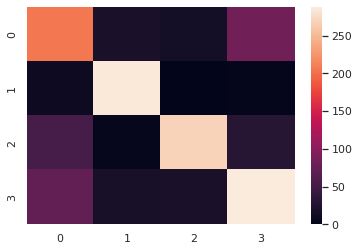

In [18]:
test_dataset = Custom_Dataset(test_X,test_lbl_idx, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=b_sz, shuffle = True)

model = torch.load("model_path.pth").to(device)

with torch.no_grad():  
  test_true, test_pred, test_batch_losses = validate_(test_dataloader)
    
  #calculate f1_score
  f1_test = f1_score(test_true, test_pred, average='weighted')

  #calculate accuracy
  test_acc = accuracy_score(test_true, test_pred, )

  #calculate loss
  test_loss = sum(test_batch_losses)/len(test_dataloader.dataset)

  print("Loss: \n test: ", test_loss)
  print(f"Accuracy: \ntest : {100*test_acc:.2f} % "  )
  print("F1 SCORE: \n  test: ", f1_test)
  print('\n confusion matrix')
  results = confusion_matrix(test_true, test_pred)
  ax = sns.heatmap(results)
torch_seed(100)

**Βήμα 2: Activation functions**

\begin{array}{ccccccccc}
\text{metric}&\text{Linear}&\text{ReLu}&\text{SELU}&\text{Softplus}&\text{Tanh}&\text{CELU}&\text{Tanhshrink}\\
F1\_score & 71.80\% & 69.84\% & 75.00\% & 72.38\% & 52.76\% & 73.62\% &  72.53\%  \\
Accuracy & 71.81\% & 69.09\% & 74.87\% & 71.44\% & 46.54\% &73.01\% & 71.49\% 
\end{array}

Since, the activation that gave the best accuracy and F1 score on "Βήμα 2", is SELU I kept this function on the following steps.

**Βήμα 4: Learning rate scheduler**

Lets remember that until now the best accuracy sccore is 75.00%.
All the schedulers below had the default values on the parameters expect from the verbose = True. For the schedulers that had extra parameters like gamma or base_lr and max_lr I tried different values and wrote down on the table below the best performance achived.
As we can se from the tabe below LinearLR gave the best accuracy score. However the overall performance is slightly better than the one reached withour the scheduler, using constant learning rate = 0.002.

\begin{array}{ccc}
\text{scheduler} &\text{accuracy} &\text{f1_score} \\ 
\text{LinearLR} & 76.74\% & 76.28\% \\ 
\text{ConstantLR} & 74.64\% & 74.53\% \\ 
\text{ExponentialLR} & 75.51\% & 75.45\% \\ 
\text{CyclicLR} & 63.52\% & 62.52\% \\ 
\text{StepLR} & 76.38\% & 76.29\% \\ 
\text{MultiStepLR} & 75.29\% & 75.28\% \\ 
\text{LambdaLR} & 72.73\% & 68.94\% \\ 
\text{MultiplicativeLR} & 75.80\% & 75.71\% \\ 
\text{SequentialLR(LinearLR+ConstantLR)} & 74.85\% & 74.80\% \\ 
\text{SequentialLR(LinearLR+ExponentialLR)} & 75.94\% & 75.53\% \\ 
\end{array}

**Βήμα 5: Batch Normalization**

Adding a batchnorm2d layer on the code above.

**Βήμα 6: Regularization**

Based on the results shown on the table below we can see that setting the weight_decay paramater of the  optimizer equal to 0.002 helps the model perform better. The dropout layer on the other hand makes the performance decrase.

\begin{array}{cccc}
\text{epochs}&\text{30}&\text{30}&\text{60}&\text{60}\\
\text{metrics}&\text{accuracy}&\text{f1_score}&\text{accuracy}&\text{f1_score}\\
\text{weight_decay}& 77.40\% & 77.41\% & 77.25\% & 77.02\%\\
\text{dropout} & 73.91\% & 73.93\% &75.29\% & 74.91\% \\
\text{both}& 73.98\% & 73.9\% & 75.15\% & 74.70\%
\end{array}

**Βήμα 7: Training efficiency**

**Batchsize** \\

Metrics (accuracy and f1_score) corresponds to the test set and the running time corresponds to the time needed for training the model for 60 epochs. As we can see the ideal batch size is 16 based on accuracy and f1 score results.
\begin{array}{ccc}
\text{batch size} & \text{accuracy} & \text{f1_score} & \text{training time (sec)} \\
1 & 75.22\% & 75.74\% & 842.597\\
2 & 73.93\% & 73.56\% & 431.311 \\
4 & 75.15\% & 74.76\% & 229.099 \\
8 & 76.94\% & 75.96\% & 124.422 \\
16 & 77.25\% & 77.02\% & 63.593\\
32 & 76.02\% & 75.76\% & 39.244\\
64 & 77.03\% & 76.90\% & 29.250\\
\end{array}


**Early stopping**

Instead of saving the version of the model which reached the best score on loss values as we were doing until now I created a new function to impement early stopping method and used that instead.

Using patience=7,  I observed that the accuracy droped a littele bit (less than 1%) but we "won" a lot time. Instead of more than 60 second we now need ony 7 sconds because the model now do not train for 60 epochs but needs only 6.

I did some experiments using different values of patience. As the patience increases the accuracy value increse but so does the time needed for training (it takes more epochs) and ....
For example for patience = 9 we get accuracy score on test set equal to 76.24% and the model need 8 epochs to conclude that equals to approximately 11 seconds.
For patience = 5, accuracy score on test set equals to 74.78% and we need only 4 epochs (approximately 5 seconds).

In [ ]:
%cd ..

# Ερώτημα 4: Testing

Youtube.py have to be uploaded.

**Βήμα 1: Inference**

In [19]:
#define dataset
class _Dataset(Dataset):
  def __init__(self,data, transform= None):
    self.data = data
    # self.targets = targets
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index]
    # y = self.targets[index]
      
    if self.transform:
      x = self.transform(x)
      # y = self.transform(y)      
    return x


In [20]:
#define prediction faction
def youtube_pred(dataloader_, model_):
    list_ = []
    # for data , lbl in next(iter(train_dataloader)):
    for x_batch in dataloader_:
      x_batch = x_batch.to(device)
      x_batch.resize_(1 , 1 , 21, 128)

      pred = model(x_batch.float())
      list_.append(pred)
    return list_

**Βήμα 2: Κατέβασμα μουσικής** & **Βήμα 3: Προβλέψεις**

In [21]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

/content
n
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 1s (168 kB/s)
Reading

In [22]:
import sys
sys.path.append('/content/youtube.py')
import youtube

Classical mussic

In [24]:
youtube.youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano') #get melgram for the link

youtube_data = np.load('youtube_melgrams.npy') #load melgrams

#dataloader
youtube_dataset = _Dataset(youtube_data, transform=None)
youtube_dataloader = DataLoader(youtube_dataset, batch_size=1, shuffle = False)

#predict
with torch.no_grad(): 
  l = youtube_pred(youtube_dataloader, model)
print(l)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 1.8111, -2.0838, -0.3381,  1.1976]], device='cuda:0'), tensor([[ 1.6397,  0.5884, -1.2138, -0.0853]], device='cuda:0'), tensor([[ 2.2027, -0.7325, -1.4834,  1.1990]], device='cuda:0'), tensor([[ 2.0140, -1.0412, -1.2488,  1.3444]], device='cuda:0'), tensor([[ 1.6942,  0.9347, -1.4328, -0.1543]], device='cuda:0'), tensor([[ 2.5025,  1.5876, -2.3738, -0.3051]], device='cuda:0'), tensor([[ 2.2892,  0.7767, -2.0857,  0.5888]], device='cuda:0'), tensor([[ 2.0850,  0.1170, -1.7282,  0.8242]], device='cuda:0'), tensor([[ 2.2977, -1.5672, -1.5295,  2.0149]], device='cuda:0'), tensor([[ 2.0695, -0.5728, -1.2678,  0.9035]], device='cuda:0'), tensor([[ 2.0584,  0.5956, -1.8755,  0.5592]], device='cuda:0'), tensor([[ 1.6714,  1.6088, -1.4319, -0.8334]], device='cuda:0'), tensor([[ 1.8705,  0.6910, -1.4159, -0.1129]], device='cuda:0'), tensor([[ 1.8623, -0.653

Pop

In [28]:
%rm youtube_melgrams.npy #delete npy file created from previous download
youtube.youtube_to_melgram('https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna') #get melgram for the link

youtube_data = np.load('youtube_melgrams.npy') #load melgrams

#dataloader
youtube_dataset = _Dataset(youtube_data, transform=None)
youtube_dataloader = DataLoader(youtube_dataset, batch_size=1, shuffle = False)

#predict
with torch.no_grad(): 
  l = youtube_pred(youtube_dataloader, model)
print(l)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 1.8111, -2.0838, -0.3381,  1.1976]], device='cuda:0'), tensor([[ 1.6397,  0.5884, -1.2138, -0.0853]], device='cuda:0'), tensor([[ 2.2027, -0.7325, -1.4834,  1.1990]], device='cuda:0'), tensor([[ 2.0140, -1.0412, -1.2488,  1.3444]], device='cuda:0'), tensor([[ 1.6942,  0.9347, -1.4328, -0.1543]], device='cuda:0'), tensor([[ 2.5025,  1.5876, -2.3738, -0.3051]], device='cuda:0'), tensor([[ 2.2892,  0.7767, -2.0857,  0.5888]], device='cuda:0'), tensor([[ 2.0850,  0.1170, -1.7282,  0.8242]], device='cuda:0'), tensor([[ 2.2977, -1.5672, -1.5295,  2.0149]], device='cuda:0'), tensor([[ 2.0695, -0.5728, -1.2678,  0.9035]], device='cuda:0'), tensor([[ 2.0584,  0.5956, -1.8755,  0.5592]], device='cuda:0'), tensor([[ 1.6714,  1.6088, -1.4319, -0.8334]], device='cuda:0'), tensor([[ 1.8705,  0.6910, -1.4159, -0.1129]], device='cuda:0'), tensor([[ 1.8623, -0.653

Rock

In [26]:
%rm youtube_melgrams.npy #delete npy file created from previous download
youtube.youtube_to_melgram('https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO') #get melgram for the link

youtube_data = np.load('youtube_melgrams.npy') #load melgrams

#dataloader
youtube_dataset = _Dataset(youtube_data, transform=None)
youtube_dataloader = DataLoader(youtube_dataset, batch_size=1, shuffle = False)

#predict
with torch.no_grad(): 
  l = youtube_pred(youtube_dataloader, model)
print(l)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 1.8111, -2.0838, -0.3381,  1.1976]], device='cuda:0'), tensor([[ 1.6397,  0.5884, -1.2138, -0.0853]], device='cuda:0'), tensor([[ 2.2027, -0.7325, -1.4834,  1.1990]], device='cuda:0'), tensor([[ 2.0140, -1.0412, -1.2488,  1.3444]], device='cuda:0'), tensor([[ 1.6942,  0.9347, -1.4328, -0.1543]], device='cuda:0'), tensor([[ 2.5025,  1.5876, -2.3738, -0.3051]], device='cuda:0'), tensor([[ 2.2892,  0.7767, -2.0857,  0.5888]], device='cuda:0'), tensor([[ 2.0850,  0.1170, -1.7282,  0.8242]], device='cuda:0'), tensor([[ 2.2977, -1.5672, -1.5295,  2.0149]], device='cuda:0'), tensor([[ 2.0695, -0.5728, -1.2678,  0.9035]], device='cuda:0'), tensor([[ 2.0584,  0.5956, -1.8755,  0.5592]], device='cuda:0'), tensor([[ 1.6714,  1.6088, -1.4319, -0.8334]], device='cuda:0'), tensor([[ 1.8705,  0.6910, -1.4159, -0.1129]], device='cuda:0'), tensor([[ 1.8623, -0.653

Blues

In [27]:
%rm youtube_melgrams.npy #delete npy file created from previous download
youtube.youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania') #get melgram for the link

youtube_data = np.load('youtube_melgrams.npy') #load melgrams

#dataloader
youtube_dataset = _Dataset(youtube_data, transform=None)
youtube_dataloader = DataLoader(youtube_dataset, batch_size=1, shuffle = False)

#predict
with torch.no_grad(): 
  l = youtube_pred(youtube_dataloader, model)
print(l)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 0.8954, -2.1451,  0.8717,  0.4368]], device='cuda:0'), tensor([[ 1.8111, -2.0838, -0.3381,  1.1976]], device='cuda:0'), tensor([[ 1.6397,  0.5884, -1.2138, -0.0853]], device='cuda:0'), tensor([[ 2.2027, -0.7325, -1.4834,  1.1990]], device='cuda:0'), tensor([[ 2.0140, -1.0412, -1.2488,  1.3444]], device='cuda:0'), tensor([[ 1.6942,  0.9347, -1.4328, -0.1543]], device='cuda:0'), tensor([[ 2.5025,  1.5876, -2.3738, -0.3051]], device='cuda:0'), tensor([[ 2.2892,  0.7767, -2.0857,  0.5888]], device='cuda:0'), tensor([[ 2.0850,  0.1170, -1.7282,  0.8242]], device='cuda:0'), tensor([[ 2.2977, -1.5672, -1.5295,  2.0149]], device='cuda:0'), tensor([[ 2.0695, -0.5728, -1.2678,  0.9035]], device='cuda:0'), tensor([[ 2.0584,  0.5956, -1.8755,  0.5592]], device='cuda:0'), tensor([[ 1.6714,  1.6088, -1.4319, -0.8334]], device='cuda:0'), tensor([[ 1.8705,  0.6910, -1.4159, -0.1129]], device='cuda:0'), tensor([[ 1.8623, -0.653

# **References**

Since the project streched along summer I did not kept track from all the sites I counseled to implement the project. I definitely used some code from the lab and also used my code from my projects from last semester in Artificial Inteligence II. 

Some links:
https://librosa.org/doc/main/auto_examples/plot_display.html
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html